<a href="https://colab.research.google.com/github/JacopoMangiavacchi/animegan2-coreml/blob/master/convert_coreml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import torch
import random
import numpy as np

In [2]:
!git clone https://github.com/jacopomangiavacchi/animegan2-coreml

Cloning into 'animegan2-coreml'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 40 (delta 8), reused 35 (delta 5), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [3]:
os.chdir(f'./animegan2-coreml')

In [4]:
from model import Generator

def load_image(path, size=None):
    image = image2tensor(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))

    w, h = image.shape[-2:]
    if w != h:
        crop_size = min(w, h)
        left = (w - crop_size)//2
        right = left + crop_size
        top = (h - crop_size)//2
        bottom = top + crop_size
        image = image[:,:,left:right, top:bottom]

    if size is not None and image.shape[-1] != size:
        image = torch.nn.functional.interpolate(image, (size, size), mode="bilinear", align_corners=True)
    
    return image

def image2tensor(image):
    image = torch.FloatTensor(image).permute(2,0,1).unsqueeze(0)/255.
    return (image-0.5)/0.5

def tensor2image(tensor):
    tensor = tensor.clamp_(-1., 1.).detach().squeeze().permute(1,2,0).cpu().numpy()
    return tensor*0.5 + 0.5

def imshow(img, size=5, cmap='jet'):
    plt.figure(figsize=(size,size))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

In [5]:
device = 'cpu'
torch.set_grad_enabled(False)
image_size = 512 # Can be tuned, works best when the face width is between 200~250 px

model = Generator().eval().to(device)

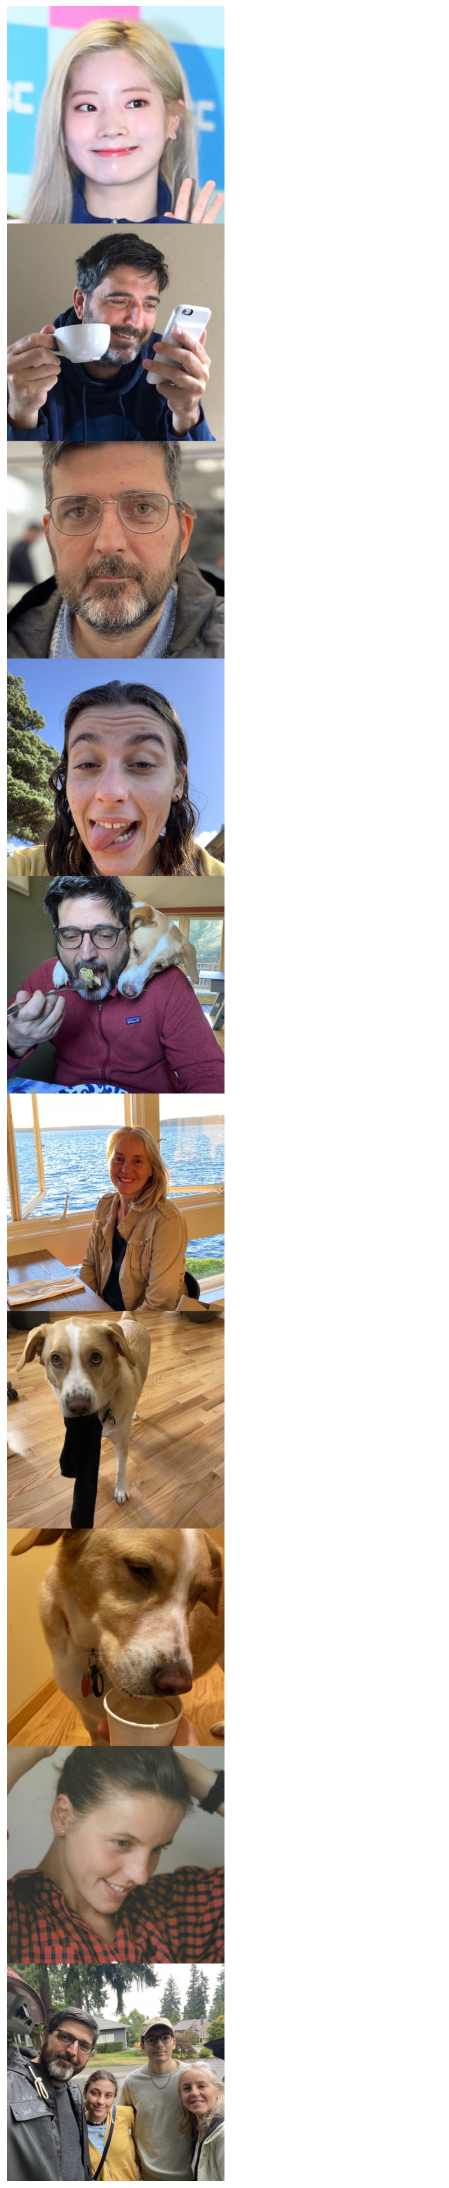

In [6]:
ckpt = torch.load(f"weights/celeba_distill.pt", map_location=device)
# ckpt = torch.load(f"weights/face_paint_512_v2.pt", map_location=device)
# ckpt = torch.load(f"weights/paprika.pt", map_location=device)
model.load_state_dict(ckpt)
    
results = []
for j in range(1,11):
    image = load_image(f"faces/{j}.jpg", image_size)
    output = model(image.to(device))

    results.append(torch.cat([image, output.cpu()], 3))
results = torch.cat(results, 2)

imshow(tensor2image(results),40)

In [7]:
!pip install coremltools

     |████████████████████████████████| 1.6 MB 5.2 MB/s 


In [8]:
image_size = 512
image = load_image(f"faces/2.jpg", image_size)
output = model(image.to(device))
image.shape, output.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 3, 512, 512]))

In [9]:
# scripted_model = torch.jit.script(model)
traced = torch.jit.trace(model, image)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2359: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  _verify_batch_size([input.size(0) * input.size(1) // num_groups, num_groups] + list(input.size()[2:]))


In [10]:
import coremltools
scale = 1/(0.226*255.0)
bias = [- 0.485/(0.229) , - 0.456/(0.224), - 0.406/(0.225)]

image_input = coremltools.ImageType(name="input_1",
                           shape=(1, 3, 512, 512),
                           scale=scale, bias=bias)

In [11]:
mlmodel = coremltools.converters.convert(
  traced,
  inputs=[image_input],
)

Running MIL Common passes:   6%|▌         | 2/34 [00:00<00:01, 19.27 passes/s]/usr/local/lib/python3.7/dist-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:129: UserWarning: Output, '457', of the source model, has been renamed to 'var_457' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 802/802 [00:00<00:00, 2230.76 ops/s]


In [12]:
mlmodel.save('animegan2-celeba-distil-512.mlmodel')